## Import libraries

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.datasets as datasets
from skimage import io
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
import time
from PIL import Image
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt

In [2]:
print("Is GPU enabled ? ",torch.cuda.is_available())

Is GPU enabled ?  False


## Parameters

In [3]:
input_size=784     # Number of input neurons(image pixels)       
epochs=30          # How many times we pass our entire dataset into our network
batch_size=100    # How many data takes each one iteration ? 
learning_rate=0.001

## Download the Dataset

In [4]:
# Prepare the transform structures to apply dataset

# To apply the transformation,we'll use standardization
# Standardization is a normalization technique which makes the mean to zero and std to 1.

# The mean and std of the dataset is known before.

transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

train_dataset = datasets.CIFAR10(root="./dataset",train=True,
                                transform=transforms,
                                download=True)

test_dataset = datasets.CIFAR10(root="./dataset",train=False,
                               transform=transforms)



Files already downloaded and verified


## Get some informations about dataset

In [5]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
len(train_dataset),len(test_dataset)

(50000, 10000)

In [7]:
train_dataset.root

'./dataset'

In [8]:
train_dataset.transforms

StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## Define classes

In [9]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Visualize random image

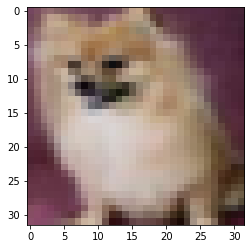

In [10]:
def showImages(img):
    img = img/2 + 0.5     # Unnormalize data
    numpyImage = img.numpy()     # Convert tensor to numpy array to display image with matplotlib
    
    # torch.tensor --> (Channel,Height,Width)
    # numpy.array -->  (Height,Width,Channel)
    
    plt.imshow(np.transpose(numpyImage,axes=(1,2,0)))
    plt.show()
    
# Choose random number
random_num = random.randint(0,len(train_dataset))

# Get image and label
random_img = train_dataset[random_num][0]
random_img_label = train_dataset[random_num][1]

showImages(random_img)



## Load the dataset

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [12]:
print(len(train_loader))
print(len(test_loader))

500
100


In [13]:
a,b = next(iter(test_loader))
a.shape

torch.Size([100, 3, 32, 32])

## Visualize some random images with batches

images.shape:  torch.Size([100, 3, 32, 32])
labels.shape:  torch.Size([100])


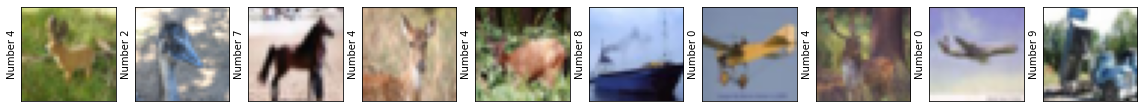

In [14]:
plt.figure(figsize=(20,16))

for i in range(10):
    
    plt.subplot(1,10,i+1)
    t_loader = iter(train_loader)
    
    images,labels = next(t_loader)
    
    img = images[i]
    label = labels[i].item()
    
    # Convert tensor to np.array to show
    img=img.numpy()*0.5+0.5
    img = np.transpose(img,(1,2,0))
    
    plt.ylabel("Number "+str(label))
    plt.imshow(img,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    
    
print('images.shape: ',images.shape)
print('labels.shape: ',labels.shape) 

## Build the CNN Model

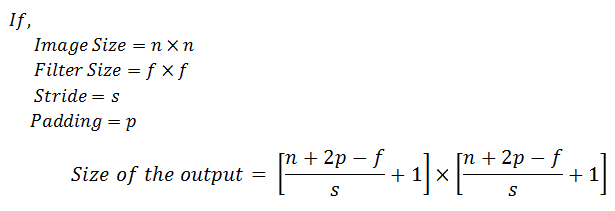

In [15]:
print(images.shape)
conv2d=nn.Conv2d(3,8,kernel_size=3,padding=1)
y=conv2d(images)
print(y.shape)

batchnorm=nn.BatchNorm2d(8)
y=batchnorm(y)
print(y.shape)

maxpool=nn.MaxPool2d(kernel_size=2)
y=maxpool(y)
print(y.shape)

conv2d=nn.Conv2d(8,32,kernel_size=5,stride=1,padding=2)
y=conv2d(y)
print(y.shape)

batchnorm=nn.BatchNorm2d(32)
y=batchnorm(y)
print(y.shape)

maxpool=nn.MaxPool2d(kernel_size=2)
y=maxpool(y)
print(y.shape)

y=y.view(-1,y.size(1)*y.size(2)*y.size(3))
print(y.shape)

y.flatten().shape


torch.Size([100, 3, 32, 32])
torch.Size([100, 8, 32, 32])
torch.Size([100, 8, 32, 32])
torch.Size([100, 8, 16, 16])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 8, 8])
torch.Size([100, 2048])


torch.Size([204800])

In [16]:
from torchsummary import summary
import torch.nn.functional as F

In [17]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,padding=1,stride=1)
        self.batchNorm1 = nn.BatchNorm2d(num_features=8)
        self.maxPool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2=nn.Conv2d(in_channels=8,out_channels=32,kernel_size=5,padding=2,stride=1)
        self.batchNorm2=nn.BatchNorm2d(num_features=32)
        
        self.fc1=nn.Linear(in_features=32*8*8,out_features=200)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(in_features=200,out_features=10)
        
    def forward(self,x):
        
        inp = self.conv1(x)
        x = self.batchNorm1(inp)
        x = F.relu(x)
        x = self.maxPool(x)
        
        x=self.conv2(x)
        x=F.relu(self.batchNorm2(x))
        x=self.maxPool(x)
        
        x=x.view(-1,32*8*8)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x
    

In [18]:
model=CNN_Model()
model

CNN_Model(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchNorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=200, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [19]:
print(model.conv1)
print(model.conv2)
print(model.conv1.weight.shape) # input->1 filtre-out->8 filter ve 3 x 3 kernel
print(model.conv2.weight.shape) # input->8 filtre-out->32 tane filtre ve 5 x 5 kernel

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
torch.Size([8, 3, 3, 3])
torch.Size([32, 8, 5, 5])


In [20]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
         MaxPool2d-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           6,432
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                  [-1, 200]         409,800
           Dropout-8                  [-1, 200]               0
            Linear-9                   [-1, 10]           2,010
Total params: 418,546
Trainable params: 418,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 1.60
Estimated Total Size (MB): 1.89
-------------------------------------------

In [21]:
for p in model.parameters():
    print(p.shape)

torch.Size([8, 3, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([32, 8, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([200, 2048])
torch.Size([200])
torch.Size([10, 200])
torch.Size([10])


## Select loss function,device and optimizer

In [22]:
# Select loss function
loss_fn = nn.CrossEntropyLoss()

# Select optimizer
optimizer = torch.optim.Adam(params=model.parameters(),lr = learning_rate)

# Select device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Train the model

In [23]:
import time

start = time.time()

# Create lists that holds the informations about model
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(epochs):
    n_correct = 0
    batch_loss = 0.0
    batch_iter = 0
    
    # Set train mode
    model.train()
    
    for i,(images,labels) in enumerate(train_loader):
        
        # Select device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass (Prediction)
        output = model(images)
        
        # Compute loss value
        loss_val = loss_fn(output,labels)
        batch_loss += loss_val.item()
        
        # Set zero to gradients
        optimizer.zero_grad()
        
        # Backward pass (Back propagation)
        loss_val.backward()
        
        # Update weights of the model
        optimizer.step()
        
        # Get predicted results
        _,pred = torch.max(output,1)
        n_correct += (pred == labels).sum().item()
        
        batch_iter += 1
    
    # Add loss values
    train_loss.append(batch_loss/batch_iter)
    train_acc.append(100*n_correct/len(train_dataset))
    
    # Evaluation mode
    n_correct = 0
    batch_loss = 0.0
    batch_iter = 0
    
    # Set evaluation mode
    model.eval()
    
    with torch.no_grad():
        for i,(images,labels) in enumerate(test_loader):
            
            # Select device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass (Prediction)
            output = model(images)
            
            # Compute loss value
            loss_val = loss_fn(output,labels)
            batch_loss += loss_val.item()
            
            # Get predicted results
            _,pred = torch.max(output,1)
            n_correct += (pred == labels).sum().item()
            
            batch_iter+=1
            
        test_loss.append(batch_loss/batch_iter)
        test_acc.append(100*n_correct/len(test_dataset))
    
        print("Epoch {}/{}, Training Loss: {:.3f}, Training Acc: {:.3f}, Testing Loss: {:.3f},Testing Acc: {:.3f}".format(
                epoch+1,epochs,train_loss[-1],train_acc[-1],test_loss[-1],test_acc[-1]))    
    
    
        
    

end = time.time()
print("Finished %.2f seconds."%(end-start))

Epoch 1/30, Training Loss: 1.556, Training Acc: 43.060, Testing Loss: 1.313,Testing Acc: 53.580
Epoch 2/30, Training Loss: 1.279, Training Acc: 53.902, Testing Loss: 1.120,Testing Acc: 60.750
Epoch 3/30, Training Loss: 1.157, Training Acc: 58.716, Testing Loss: 1.028,Testing Acc: 63.890
Epoch 4/30, Training Loss: 1.080, Training Acc: 61.682, Testing Loss: 0.955,Testing Acc: 66.600
Epoch 5/30, Training Loss: 1.022, Training Acc: 63.634, Testing Loss: 0.926,Testing Acc: 67.490
Epoch 6/30, Training Loss: 0.978, Training Acc: 65.342, Testing Loss: 0.905,Testing Acc: 68.210
Epoch 7/30, Training Loss: 0.945, Training Acc: 66.494, Testing Loss: 0.862,Testing Acc: 69.590
Epoch 8/30, Training Loss: 0.903, Training Acc: 68.186, Testing Loss: 0.866,Testing Acc: 69.570
Epoch 9/30, Training Loss: 0.879, Training Acc: 68.720, Testing Loss: 0.860,Testing Acc: 70.150
Epoch 10/30, Training Loss: 0.856, Training Acc: 69.532, Testing Loss: 0.890,Testing Acc: 69.160
Epoch 11/30, Training Loss: 0.826, Trai

## Plot the loss

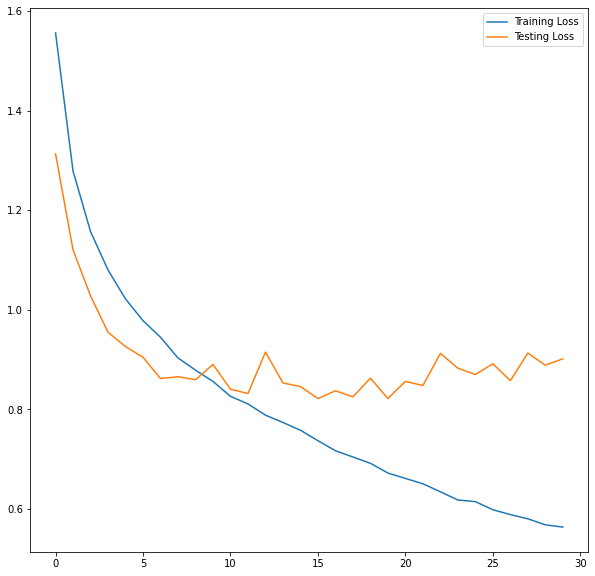

In [24]:
plt.figure(figsize=(10,10))
plt.plot(train_loss,label="Training Loss")
plt.plot(test_loss,label="Testing Loss")
plt.legend()
plt.show()

## Plot the accuracy

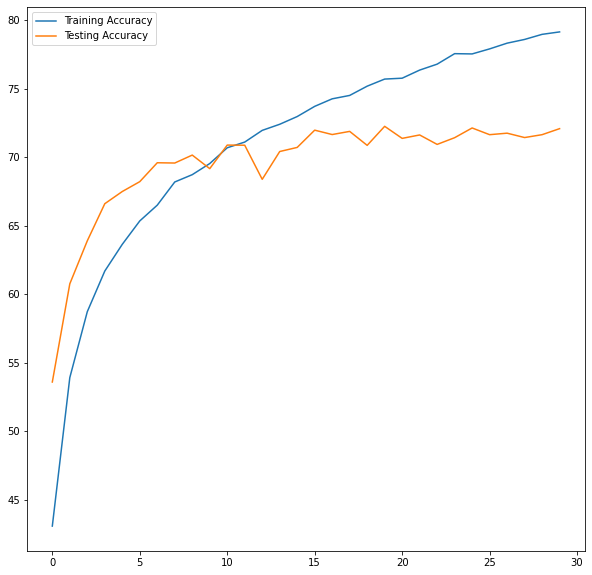

In [25]:
plt.figure(figsize=(10,10))
plt.plot(train_acc,label="Training Accuracy")
plt.plot(test_acc,label="Testing Accuracy")
plt.legend()
plt.show()


## Save the model

In [28]:
# Save model
torch.save(model,"./model/cifar10_model.pth")

# Save model weights
torch.save(model.state_dict(),"./model/cifar10_modelWeights.pth")

print("Model saved successfully!")

Model saved successfully!


## Load the model

In [29]:
# Load model directly
model = torch.load("./model/cifar10_model.pth")
print("Model loaded succesfully!")

Model loaded succesfully!


In [31]:
# Load model weights (Recommended)
model = CNN_Model()
model.load_state_dict(torch.load("./model/cifar10_modelWeights.pth"))
print("Model weights loaded succesfully!")

Model weights loaded succesfully!
